In [1]:

import numpy as np 
import torch
import matplotlib.pyplot as plt
from typing import List
from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

from utilities.pg_utils import set_seed
#set_seed(111)

In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059


torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-01-01"  # start date of trading
end_date = "2024-09-30"
N_EPISODES = 5  # number of episodes to train the agent
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date, end_date=end_date)
# kraken_ds = KrakenDataSet(portfolio, WINDOW_SIZE)
agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE)



In [ ]:
# train agent
agent.train(N_EPISODES);

Training Started for DDPG Agent
episode 1 sigma: 0.4
iteration 6000 sigma: 0.26462110289031693
iteration 8000 sigma: 0.19190080981620095
iteration 10000 sigma: 0.12695833705508772
iteration 12000 sigma: 0.07662627758291086
Episode 1 - Actor Loss: -0.0058, Critic Loss: 0.3021, Total Normalized Reward in Episode: 12804.6680, True Episodic Reward: 1.5594
episode 2 sigma: 0.396
iteration 2000 sigma: 0.3782258971523671
iteration 4000 sigma: 0.3295637401853167
iteration 6000 sigma: 0.2619748918614126
iteration 8000 sigma: 0.18998180171803836
iteration 10000 sigma: 0.12568875368453628
iteration 12000 sigma: 0.07586001480708143
Episode 2 - Actor Loss: -0.0393, Critic Loss: 0.3466, Total Normalized Reward in Episode: 7693.0996, True Episodic Reward: -2.9765
episode 3 sigma: 0.392
iteration 2000 sigma: 0.3744054335447685
iteration 4000 sigma: 0.32623481351677813
iteration 6000 sigma: 0.25932868083251
iteration 8000 sigma: 0.18806279361987666
iteration 10000 sigma: 0.12441917031398562


In [6]:
#import pickle
#with open("my_ddpg_agent.pkl", "wb") as f:
    #pickle.dump(agent, f)



In [ ]:
import pickle
with open("my_ddpg_agent.pkl", "rb") as f:
    agent = pickle.load(f)

In [20]:
np.set_printoptions(suppress=True)

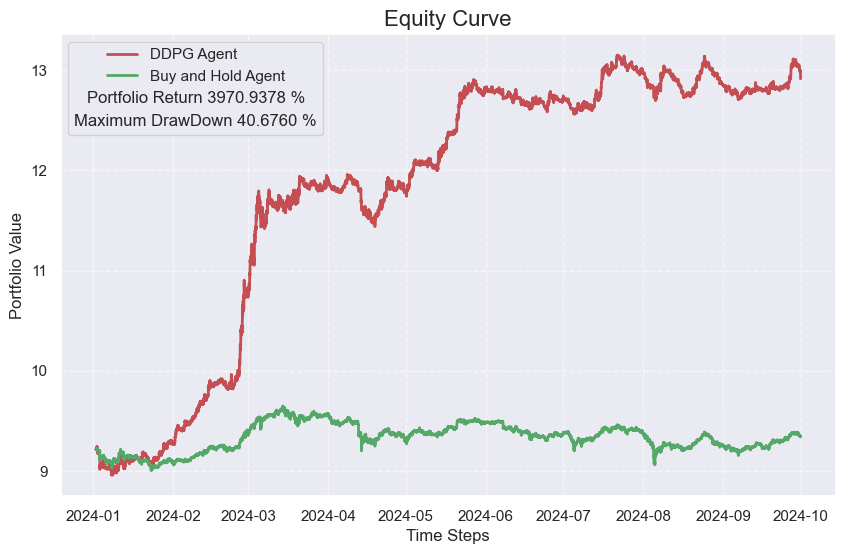

In [30]:
# checking pvm as it should be similar to buy and hold prior to training
import seaborn as sns
import matplotlib.offsetbox as offsetbox
weights = []
ds = KrakenDataSet(portfolio, 50, 1)
cl_price = portfolio.get_close_price()
dates = cl_price.index

sns.set_theme()
pf_previous = 10000
agent_equity_curve = [pf_previous]
total_reward = 0
weights = []



for i in range(len(ds) + 49):
    Xt, prev_index = ds[i]
    yt = 1 / Xt[0, :, -2]
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    weights.append(wt.cpu().numpy())
    reward = torch.dot(wt, yt) 
    pf_current = pf_previous * reward
    agent_equity_curve.append(pf_current.item())
    pf_previous = pf_current

# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(dates[49:], np.log(agent_equity_curve), label="DDPG Agent", linewidth=2, color='r')
plt.plot(dates[49:], np.log(buy_and_hold_equity), label="Buy and Hold Agent", linewidth=2, color='g')
plt.title("Equity Curve", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

final_return = agent.portfolio.calculate_final_equity_return(agent_equity_curve)
mdd = agent.portfolio.calculate_max_drawdown(agent_equity_curve)
#plt.legend(loc='best');
a = plt.legend(loc='best')
txt=offsetbox.TextArea(f"Portfolio Return {final_return:.4f} %")
txt2=offsetbox.TextArea(f"Maximum DrawDown {mdd:.4f} %")
box = a._legend_box
box.get_children().append(txt)
box.get_children().append(txt2)
box.set_figure(box.figure)

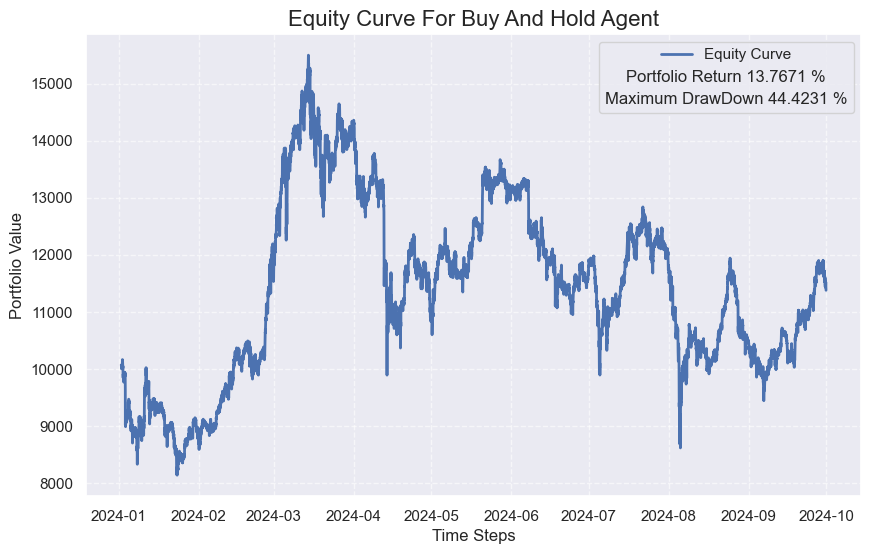

In [22]:
# buy and hold
buy_and_hold_weights = np.ones(12) / 12 # Equal allocation
buy_and_hold_equity = [10000]
pf_previous = 10000

for i in range(len(ds) + 49):
    Xt, _ = ds[i]
    yt = 1 / Xt[0, :, -2] # Price relatives
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    reward = np.dot(buy_and_hold_weights, yt.cpu().numpy())  # No rebalancing
    pf_current = pf_previous * reward
    buy_and_hold_equity.append(pf_current)
    pf_previous = pf_current

cl_price = portfolio.get_close_price()
dates = cl_price.index
plt.figure(figsize=(10, 6))
plt.plot(dates[49:], buy_and_hold_equity, label="Equity Curve", linewidth=2)
plt.title("Equity Curve For Buy And Hold Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
final_return = agent.portfolio.calculate_final_equity_return(buy_and_hold_equity)
mdd = agent.portfolio.calculate_max_drawdown(buy_and_hold_equity)
#plt.legend(loc='best');
a = plt.legend(loc='best')

txt=offsetbox.TextArea(f"Portfolio Return {final_return:.4f} %")
txt2=offsetbox.TextArea(f"Maximum DrawDown {mdd:.4f} %")
box = a._legend_box
box.get_children().append(txt)
box.get_children().append(txt2)
box.set_figure(box.figure)

In [10]:
rewards = [exp.reward for exp in agent.replay_memory.buffer]

Reward Min: -14.260293946249531, Reward Max: 13.20143135519574
Reward Mean: 0.021240092854266306, Reward Std: 0.9265191851598126


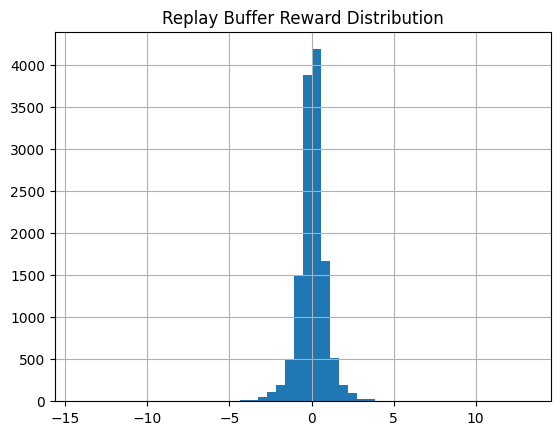

In [11]:
import matplotlib.pyplot as plt
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50)
plt.title("Replay Buffer Reward Distribution")

plt.grid()

In [ ]:
np.random.uniform(
                -3, 3
            )  # Simulate expected reward range

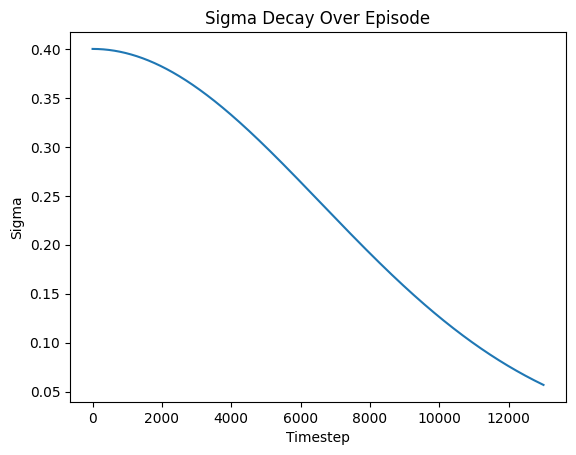

In [43]:
import matplotlib.pyplot as plt
import numpy as np

sigma_values = []
sigma = 0.4  # Initial sigma
decay_rate_within_episode = 0.0003
min_sigma = 0.05
n_samples = 13_000

for t in range(1, n_samples + 1):
    dt = t / n_samples
    sigma = max(sigma * np.exp(-dt * decay_rate_within_episode), min_sigma)
    sigma_values.append(sigma)

plt.plot(range(1, n_samples + 1), sigma_values)
plt.title("Sigma Decay Over Episode")
plt.xlabel("Timestep")
plt.ylabel("Sigma")
plt.show()


In [29]:
sigma_values[13000:]

[]

In [46]:
close_pr = agent.portfolio.get_close_price()



<Axes: xlabel='date'>

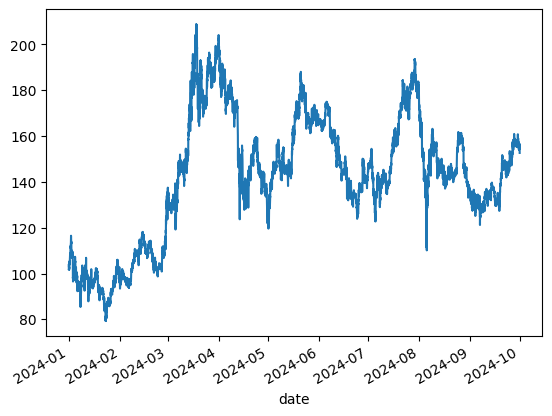

In [65]:
close_pr['SOL'].plot()

<Axes: xlabel='date'>

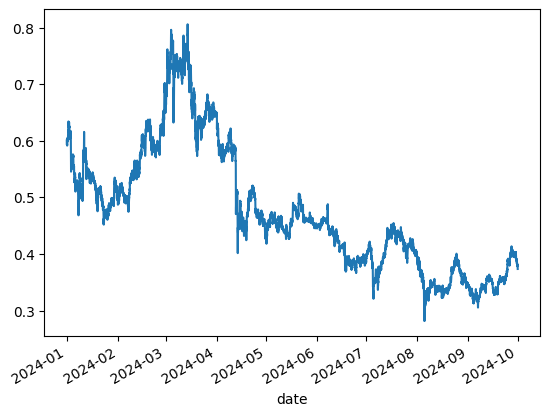

In [79]:
close_pr['ADA'].plot()

In [49]:
close_pr.head()

,CASH,SOL,ADA,USDT,AVAX,LINK,DOT,PEPE,ETH,XRP,TRX,MATIC
date,,,,,,,,,,,,
2024-01-01 00:00:00,1.0,101.91,0.594590,0.99989,38.68,15.03773,8.2346,0.000001,2290.64,0.61581,0.108090,0.9741
2024-01-01 00:30:00,1.0,101.99,0.597943,0.99982,38.92,15.11761,8.2733,0.000001,2295.00,0.61617,0.108273,0.9839
2024-01-01 01:00:00,1.0,102.43,0.600852,0.99983,39.11,15.12114,8.2809,0.000001,2298.68,0.61669,0.108042,0.9859
2024-01-01 01:30:00,1.0,104.10,0.602324,0.99963,39.35,15.16060,8.2882,0.000001,2302.33,0.61840,0.108150,0.9907
2024-01-01 02:00:00,1.0,103.59,0.600198,0.99981,39.09,15.10831,8.2635,0.000001,2297.01,0.61679,0.107985,0.9896
